# AirBnb Feature importance modelling

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)
import os
import calendar
from datetime import datetime
from scipy import stats
from matplotlib import pyplot as plt
import sys
import importlib
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge

In [78]:

from utils.data_proc_utils import get_files, proc_calendar, listing_proc, listing_proc_dummies, listing_proc_drop
from utils.analysis_utils import identify_outliers, check_missing, check_missing_dict, find_redundent_columns, CustomImputer, get_ccp_path, optimise_dt, impute, normalise, optimal_regularisation, errors_to_df, get_optimal_model_params

In [77]:
importlib.reload(sys.modules['utils.data_proc_utils'])
importlib.reload(sys.modules['utils.analysis_utils'])

<module 'utils.analysis_utils' from 'c:\\Users\\matth\\air_bnb_project\\utils\\analysis_utils.py'>

### Get and process the data

In [28]:

all_data = get_files()
_, listings_df, _ = all_data['calendar.csv'], all_data['listings.csv'], all_data['reviews.csv']
processed_listings_df = listing_proc(listings_df)

### Questionable outliers confirmed in EDA, I therefore drop rows where price is greater than 3 standard deviations of the mean, dropping 34 observations in the process

In [29]:
filt_3sd_price = identify_outliers(processed_listings_df, 'price', 3)
processed_listings_df = processed_listings_df[~filt_3sd_price]


### There are several redundent columns the below list shows columns with only one value

In [13]:
find_redundent_columns(processed_listings_df)

['scrape_id',
 'last_scraped',
 'experiences_offered',
 'state',
 'country_code',
 'country',
 'calendar_last_scraped',
 'requires_license']

In [14]:
keeps = ['guests_included',
 'neighbourhood_cleansed',
 'number_of_reviews',
 'room_type',
 'minimum_nights',
 'host_identity_verified',
 'reviews_per_month',
 'instant_bookable',
 'security_deposit_flag',
 'cleaning_fee_flag',
 'bedrooms',
 'host_tenure_days',
 'price',
 'cancellation_policy',
 'number_of_amenities',
 'host_total_listings_count',
 'bathrooms',
 'review_scores_rating',
 'extra_people']

In [30]:
drops = list(set(processed_listings_df) - set(keeps))
to_dummy = ['host_identity_verified', 'neighbourhood_cleansed', 'cancellation_policy','room_type']

### Drop additional columns and create dummy variables

In [31]:
processed_listings_df = listing_proc_drop(processed_listings_df, drops)

for col in to_dummy:
    processed_listings_df = pd.concat([processed_listings_df.drop(col, axis=1), pd.get_dummies(processed_listings_df[col] ,             dummy_na=False, prefix = col, prefix_sep = '_', drop_first=False)], axis=1)
    

### Rather than all get dummies to drop first I will manually drop in order to provide a more natural model interpretation, (e.g. drop shared room to provide better meaning to the entire home/ private room variables)

In [32]:
processed_listings_df = processed_listings_df.drop(['host_identity_verified_f', 'neighbourhood_cleansed_Allston', 'cancellation_policy_flexible', 'room_type_Shared room'], axis=1)

In [34]:
{col: sum(processed_listings_df[col].isna()) for col in processed_listings_df if sum(processed_listings_df[col].isna()) > 0}

{'bathrooms': 14,
 'bedrooms': 10,
 'review_scores_rating': 799,
 'reviews_per_month': 743}

### Whilst not best practice, due to the extremely small fraction of missing values for bathrooms and bedrooms I impute them using the median outside of the cross validation loop

In [18]:
processed_listings_df['bathrooms'] = processed_listings_df['bathrooms'].fillna(processed_listings_df['bathrooms'].median()) 
processed_listings_df['bedrooms'] = processed_listings_df['bedrooms'].fillna(processed_listings_df['bedrooms'].median()) 

### Ensure the columns are numeric for sklearn

In [35]:
for col in processed_listings_df:
    processed_listings_df[col] = pd.to_numeric(processed_listings_df[col], errors='coerce')

### Split into test and training sets

In [38]:
X_train, X_test, y_train, y_test = train_test_split(processed_listings_df.drop(['price'],axis=1), processed_listings_df['price'], test_size = 0.4, random_state=200)

### Define folds for cross validation, defined here so that all models are evaluated on the same splits

In [39]:
folds = KFold(n_splits = 10, shuffle=True, random_state = 222)

## Decision Tree Regressor

In [51]:
# get cost complexity pruning path
dt_reg = DecisionTreeRegressor()
ccp_alpha = get_ccp_path(dt_reg, X_train, y_train).ccp_alphas[:-1]
print(len(ccp_alpha))

1598


In [61]:

dt_mse, dt_r2= optimise_dt(ccp_alpha, DecisionTreeRegressor, folds, X_train, y_train)


In [63]:
dt_r2_df, dt_mse_df = errors_to_df(dt_r2, dt_mse)

<AxesSubplot:xlabel='param'>

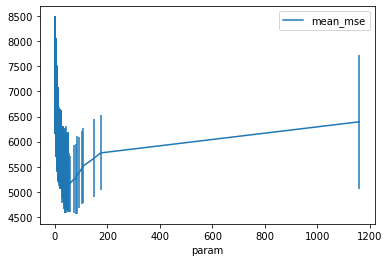

In [65]:
dt_mse_df.plot(x='param', y='mean_mse', yerr='std_mse')

<AxesSubplot:xlabel='param'>

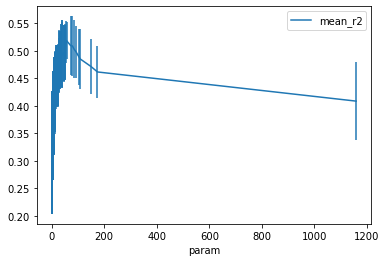

In [66]:
dt_r2_df.plot(x='param', y='mean_r2', yerr='std_r2')

In [68]:
get_optimal_model_params(dt_r2_df, 'r2', '_max'), get_optimal_model_params(dt_mse_df, 'mse', '_min')

(          param   mean_r2    std_r2
 1588  56.314751  0.518337  0.033634,
           param     mean_mse     std_mse
 1588  56.314751  5160.847052  562.290122)

In [73]:
optimal_ccp = float(get_optimal_model_params(dt_r2_df, 'r2', '_max')['param'])
c = CustomImputer()
c.fit(X_train)
X_train_imputed = c.transform(X_train)
final_dt = DecisionTreeRegressor(ccp_alpha = optimal_ccp, random_state = 1)
final_dt.fit(X_train_imputed, y_train)
important_features = final_dt.feature_importances_

In [74]:
for i,j in zip(X_train.columns,important_features):
    if j > 0.0:
        print(i,j)

host_total_listings_count 0.012767332401331202
bathrooms 0.23254004889578003
bedrooms 0.03995203045907855
guests_included 0.013786436053662131
neighbourhood_cleansed_Back Bay 0.017695416947156935
neighbourhood_cleansed_Beacon Hill 0.00915385853932456
neighbourhood_cleansed_South Boston Waterfront 0.01687560694767519
neighbourhood_cleansed_South End 0.012547522298228432
cancellation_policy_super_strict_30 0.012920499616963966
room_type_Entire home/apt 0.6317612478407989


## Regularised regression models

In [75]:
initial_alpha = np.linspace(0.01, 1., 100)

In [79]:
lasso_mse_average, lasso_r2_average = optimal_regularisation(initial_alpha, Lasso, folds, X_train, y_train)
ridge_mse_average, ridge_r2_average = optimal_regularisation(initial_alpha, Ridge, folds, X_train, y_train)

In [80]:
lasso_r2_df, lasso_mse_df = errors_to_df(lasso_r2_average,lasso_mse_average)
ridge_r2_df, ridge_mse_df = errors_to_df( ridge_r2_average, ridge_mse_average)

<AxesSubplot:xlabel='param'>

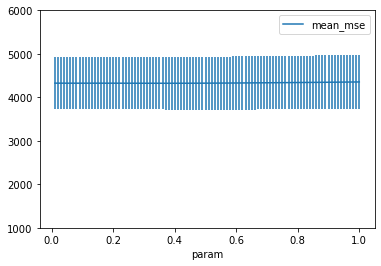

In [81]:
lasso_mse_df.plot(x='param', y='mean_mse', yerr='std_mse', ylim=(1_000,6_000))

<AxesSubplot:xlabel='param'>

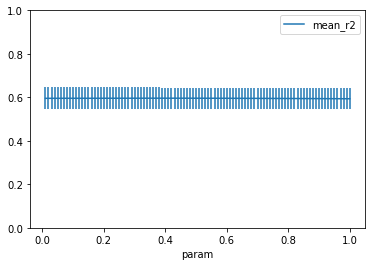

In [84]:
lasso_r2_df.plot(x='param', y='mean_r2', yerr='std_r2', ylim=(0,1))

<AxesSubplot:xlabel='param'>

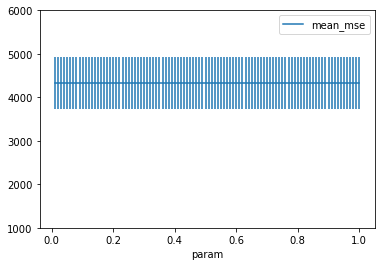

In [85]:
ridge_mse_df.plot(x='param', y='mean_mse', yerr='std_mse', ylim=(1_000,6_000))

<AxesSubplot:xlabel='param'>

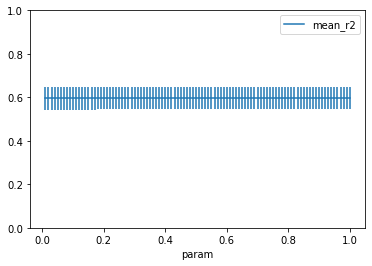

In [86]:
ridge_r2_df.plot(x='param', y='mean_r2', yerr='std_r2', ylim=(0,1))

In [87]:
get_optimal_model_params(lasso_r2_df, 'r2', '_max'), get_optimal_model_params(lasso_mse_df, 'mse', '_min')

(    param  mean_r2    std_r2
 40   0.41  0.59603  0.049083,
     param     mean_mse     std_mse
 36   0.37  4323.596948  603.307449)

In [88]:
get_optimal_model_params(ridge_r2_df, 'r2', '_max'), get_optimal_model_params(ridge_mse_df, 'mse', '_min')

(    param   mean_r2    std_r2
 99    1.0  0.595427  0.051277,
     param     mean_mse    std_mse
 99    1.0  4326.363661  591.61196)

In [89]:
c = CustomImputer()
c.fit(X_train)
X_train_lasso = c.transform(X_train)
s = StandardScaler()
X_train_lasso = s.fit_transform(X_train_lasso)

In [91]:
opt_alpha = float(get_optimal_model_params(lasso_r2_df, 'r2', '_max')['param'])
lasso_opt = Lasso(alpha=opt_alpha, random_state=1)

In [92]:
lasso_opt.fit(X_train_lasso, y_train)

Lasso(alpha=0.41000000000000003, random_state=1)

In [93]:
importance = lasso_opt.coef_
features = [i.replace("neighbourhood_cleansed_",'').replace("room_type_",'') for i in X_train.columns]
sign = [np.sign(i) for i in importance]

feature_array = []
for i, j, k in zip(features, np.abs(importance), sign):
    feature_array.append([i,j,k])

lasso_features = pd.DataFrame(feature_array, columns = ['features', 'coef_abs', 'sign']).sort_values(by = 'coef_abs', ascending=False)

In [94]:
top_25 = lasso_features[:25]

In [95]:
colours = []
for i in top_25['sign']:
    if i > 0:
        colours.append('g')
    else:
        colours.append('r')

In [96]:
top_25

,features,coef_abs,sign
42,Entire home/apt,32.218922,1.0
2,bedrooms,31.627314,1.0
15,Back Bay,22.252861,1.0
36,South End,16.104370,1.0
35,South Boston Waterfront,15.557865,1.0
22,Downtown,15.128412,1.0
17,Beacon Hill,14.201771,1.0
24,Fenway,13.631309,1.0
1,bathrooms,10.790257,1.0
3,guests_included,10.411946,1.0


<AxesSubplot:ylabel='features'>

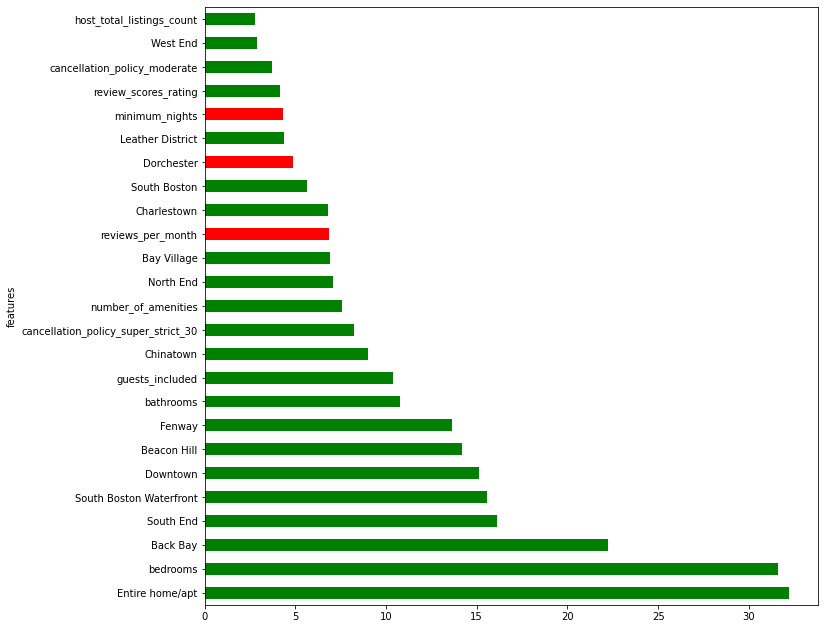

In [97]:
top_25.plot.barh(x='features', y = 'coef_abs', color=colours, figsize=(11, 11), legend=False)